# Maze

This notebook illustrates the concepts and algorithms of reinforcement learning to esc a maze.

In [42]:
import numpy as np
from scipy import sparse

In [49]:
from utils import display_maze, display_policy, display_value, display_diff_policy, normalize_sparse, get_moves

## Model

In [50]:
maze = sparse.load_npz('maze.npz')

In [57]:
display_maze?

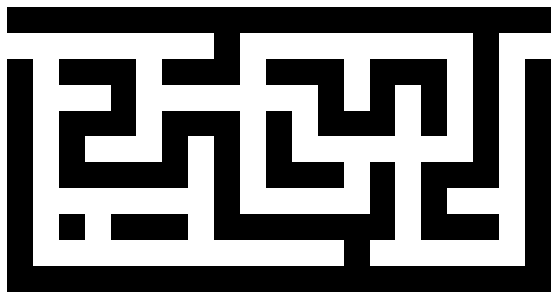

In [56]:
scale = 2
display_maze(maze, scale = scale)

In [60]:
states_terminal = [(1,20)]

In [68]:
from scipy.sparse import coo_matrix
com = coo_matrix(maze).toarray()
com

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0],
       [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [69]:
class Model():
    """
    Attributes
    ----------
    maze: sparse csr matrix
        Binary map of the maze
    states: list of tuples
        States
    states_terminal: list of tuples
        Terminal states
    state_id: dict
        Id of each state
    terminals: numpy array
        Ids of terminal states        
    actives: numpy array
        Ids of non terminal states
    adjacency: sparse csr matrix
        Matrix of adjacent ids 
    rewards: numpy array
        Reward of each state
    gamma: float (default = 1)
        Discount factor
    """
    def __init__(self, maze, states_terminal = None, gamma = 1):
        n = maze.nnz #number of non zeros
        maze_coo = sparse.coo_matrix(maze)
        states = [(maze_coo.row[i], maze_coo.col[i]) for i in range(n)]

        if states_terminal is None:
            states_terminal = [np.random.choice(states)]

        state_id = {s:i for i, s in enumerate(states)}

        terminals = np.array([state_id[s] for s in states_terminal])
        actives = np.setdiff1d(np.arange(n), terminals)

        row = []
        col = []
        for (i,j) in state_id:
            if (i + 1, j) in state_id:
                row.append(state_id[(i, j)])
                col.append(state_id[(i + 1, j)])
            if (i, j + 1) in state_id:
                row.append(state_id[(i, j)])
                col.append(state_id[(i, j + 1)])
        adjacency = sparse.csr_matrix((np.ones_like(row), (row, col)), shape = (n, n))   
        
        rewards = -np.ones(n)
        
        self.maze = maze
        self.states = states
        self.states_terminal = states_terminal
        self.state_id = state_id
        self.terminals = terminals
        self.actives = actives
        self.adjacency = adjacency + adjacency.T
        self.rewards = rewards
        self.gamma = 1

In [70]:
model = Model(maze, states_terminal)

In [71]:
len(model.states)

105

In [75]:
model.adjacency.toarray()

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]], dtype=int64)

In [76]:
len(model.actives)

104

In [86]:
model.states[100]

(9, 15)

## Policy Iteration

The policy is defined as a sparse transition matrix between states.

In [87]:
normalize_sparse?

In [88]:
# random policy  policy = normalize_sparse()

transition = normalize_sparse(model.adjacency)
teleportation = 0.5*np.ones(len(model.states))
policy = (transition,teleportation)


#transition =((1-teleportation)*transition_dense.T + teleportation*random_dense.T).T

In [89]:
def evaluate_policy(policy, V = None, model = model, n_iter_eval = 1000):
    """Evaluate a policy by iterations, starting from V"""
    rewards = model.rewards
    gamma = model.gamma
    terminals = model.terminals
    transition = policy
    if V is None:
        V = np.zeros_like(rewards)
    for t in range(n_iter_eval):
        V = transition.dot(rewards + gamma * V)  #passage dun état à un autre
        V[terminals] = 0
    return V

In [92]:
# transition_dense = np.array(transition.todense()) #rendre la matrice 
# transition_dense[0]
# random_dense = np.ones_like(transition_dense)/len(model.states)

In [91]:
def get_policy_from_value(V, model = model):
    """Get the greedy policy associated with V"""
    n = len(model.states)
    actives = model.actives
    rewards = model.rewards
    gamma = model.gamma
    row = []
    col = []
    for i in actives:
        indices = model.adjacency[i].indices
        values = (rewards + gamma * V)[indices]
        j = indices[np.argmax(values)]
        row.append(i)
        col.append(j)
    policy = normalize_sparse(sparse.csr_matrix((np.ones_like(row), (row, col)), shape = (n, n)))
    return policy    

In [ ]:
teleportation =np.ones

In [26]:
def iterate_policy(policy, model = model, n_iter_max = 100, n_iter_eval = 1000, verbose = True):
    """Get the optimal policy by policy iteration"""
    V = None
    policy_prev = sparse.csr_matrix(policy.shape)
    t = 0
    while (policy - policy_prev).nnz and t < n_iter_max:
        V = evaluate_policy(policy, V, model, n_iter_eval)
        policy_prev = policy.copy()
        policy = get_policy_from_value(V, model)
        t += 1
    if verbose:
        print("Number of iterations =", t - 1)
    return policy

In [27]:
policy = iterate_policy(policy)
V = evaluate_policy(policy)

Number of iterations = 5


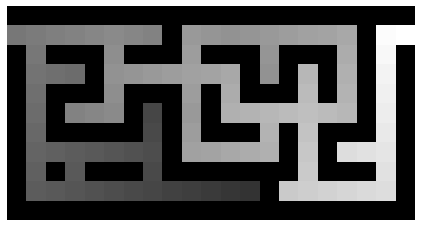

In [28]:
display_value(model.maze, V, scale = scale)

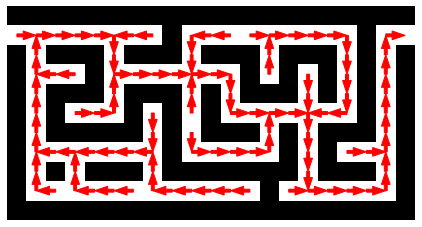

In [29]:
moves = get_moves(policy, model)
display_policy(model.maze, moves, scale = scale)

## Value iteration

In [33]:
# initial values
V = np.zeros(len(model.states))

In [34]:
def iterate_value(V, model = model, n_iter = 100, verbose = True):
    """Get the optimal policy by value iteration"""
    policy = get_policy_from_value(V, model)
    for t in range(n_iter):
        V = evaluate_policy(policy, V, model, 1)
        policy = get_policy_from_value(V, model)
    return policy

In [35]:
policy = iterate_value(V)

In [36]:
V = evaluate_policy(policy)

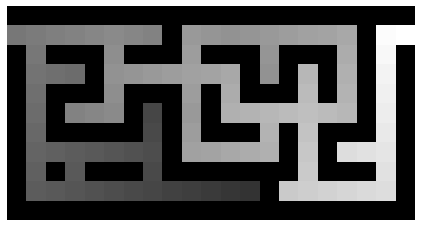

In [37]:
display_value(model.maze, V, scale = scale)

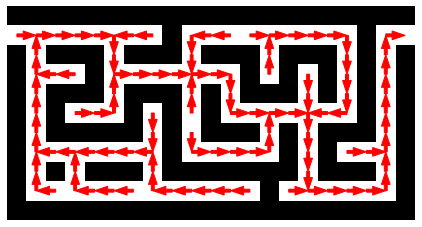

In [38]:
moves = get_moves(policy, model)
display_policy(model.maze, moves, scale = scale)

## SARSA

In [39]:
n_iter = 100000

In [ ]:
# initial values of Q
Q = normalize_sparse(model.adjacency)
Q.data = np.zeros_like(Q.data)

In [ ]:
# action is identified with new state (after move)

def sarsa(Q, model = model, alpha = 0.1, eps = 0.1, n_iter = 100):
    terminals = model.terminals
    rewards = model.rewards
    gamma = model.gamma
    # random state (not terminal)
    state = np.random.choice(np.setdiff1d(np.arange(len(model.states)), terminals))
    # random action
    action = np.random.choice(Q[state].indices)
    new_state = action
    for t in range(n_iter):
        state_prev = state
        action_prev = action
        state = new_state
        if state in terminals:
            # restart
            state = np.random.choice(np.setdiff1d(np.arange(len(model.states)), terminals))
            action = np.random.choice(Q[state].indices)
            Q[state_prev, action_prev] = (1 - alpha) *  Q[state_prev, action_prev] + alpha * rewards[action_prev]
        else:
            best_action = Q[state].indices[np.argmax(Q[state].data)]
            if np.random.random() < eps:
                action = np.random.choice(Q[state].indices)
            else:
                action = best_action
            Q[state_prev, action_prev] = (1 - alpha) *  Q[state_prev, action_prev] + alpha * (rewards[action_prev] + gamma * Q[state, action])
        new_state = action
    return Q

In [ ]:
def get_policy_from_action_value(Q, model = model):
    """Get the greedy policy associated with Q"""
    n = len(model.states)
    row = []
    col = []
    for i in range(n):
        indices = Q[i].indices
        j = indices[np.argmax(Q[i].data)]
        row.append(i)
        col.append(j)
    policy = normalize_sparse(sparse.csr_matrix((np.ones_like(row), (row, col)), shape = (n, n)))
    return policy    

In [ ]:
Q = sarsa(Q, n_iter = n_iter)

In [ ]:
policy = get_policy_from_action_value(Q)

In [ ]:
moves = get_moves(policy, model)
display_policy(model.maze, moves, scale)